# <span style='background-color: #fff5b1'>오늘의 한 걸음  🚶🏽‍♂️: 임베딩 편향성 파악하기</span>

## Contexts

### 1. READY
    1-1 오늘의 Exp와 Rubric  
    1-2 사용하는 라이브러리  

### 2. GAME
    2-1. 데이터 읽어오기  
    2-2. Embedding 
    2-3. TF-IDF  
    2-4. WEAT score 평가
        -1. WEAT score 구현
        -2. 시각화

### 3. POTG (best Play Of The Game
    3-1. 소감(POTG)  
    3-2. 어려웠던 점과 극복방안  

---


# 1. Ready
## 1-1. 오늘의 Exp와 Rubric


우리 인간들은 지들이 다 정의롭고 균형있고 바람직하다고 생각하지만  
사실은 아니다.  

아무리 착하고 올곧은 사람이라도 그 사람이 살아온  
환경과 문화, 생활패턴에 의해 무의식적으로  

'편향'을 가지게 된다.

예를 들어, 지금 한번 한창 김치찌개를 끓이고 맛을 보는 주부를 생각해보라.
여성을 떠올리지 않았는가?

우리의 무의식적인 편향은 자연스럽게 우리의 텍스트를 가지고 학습하는  
인공지능에게도 그대로 되물림된다.

때문에 우리는 NLP 를 다룰 때, 학습된 단어간의 유사도에  
편향이 섞여있는지를 꼭 판단해 보아야 한다.

오늘은 그러한 편향, Association 을 

WEAT 을 사용해 판단하는 방법을 배워보도록 한다.  
[편향성 측정지표 WEAT](https://arxiv.org/pdf/1608.07187.pdf)


: word Embedding Association Test

오늘으 Rubric 은 다음과 같다.

|평가문항|상세기준|
|--|--|
|1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.|워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.|
|2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.|타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.|
|3. WEAT score 계산 및 시각화를 정상적으로 진행하였다.|전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.|

## 1-2. 사용하는 라이브러리

In [4]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


import konlpy
from konlpy.tag import Okt

import gensim
from gensim.models import Word2Vec

import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.5.2
4.1.2
1.0
0.11.2


# 2. GAME
## 2-1. 데이터 읽어오기

In [2]:
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/goingDeeper/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:
                res.append(w[0])
        tokenized.append(res)

In [7]:
tokenized[:4]

[['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분'],
 ['시절', '상처', '아버지', '박인환', '분', '고모', '신신애', '분', '살'],
 ['겨울', '그', '지방', '방송국', '라디오', '은수', '이영애', '분', '를'],
 ['자연', '소리', '채집', '라디오', '프로그램', '준비', '은수', '상우', '녹음', '여행']]

## 2-2.Embedding

In [8]:
# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  


# Gensim 3.X 에서는 아래와 같이 생성합니다. 업데이트 되면서 바뀌었습니다
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
# model.most_similar(positive=['영화'])

In [10]:
model.wv.most_similar(positive=['영화'])

[('작품', 0.894401490688324),
 ('다큐멘터리', 0.8442175388336182),
 ('드라마', 0.8080646395683289),
 ('영화로', 0.7957452535629272),
 ('형식', 0.781740665435791),
 ('에마데딘', 0.7739892601966858),
 ('주제', 0.7736921906471252),
 ('인터뷰', 0.7647334337234497),
 ('감동', 0.7622997164726257),
 ('코미디', 0.7593784332275391)]

target, atribute 단어 셋 만들기

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/goingDeeper/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:   #, "Adjective", "Verb"]
                    result.append((word[0]))
    return ' '.join(result) 

In [14]:
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [15]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [16]:
m1 = X[0].tocoo()
m2 = X[1].tocoo()

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)
w2.sort(key=lambda x: x[1], reverse=True)

for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')
    

for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [17]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in w2v.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in w2v.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [18]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [19]:
print(target_gen)


['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


## 2-3. TD-IDF

In [20]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [21]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


WEAT score 를 판별하기 위해서는  X,Y ,A, B 를 선정해야 한다.

그러므로 TF-IDF 를 이용해 각 장르를 대표하는 단어를 뽑아 와 보도록 한다.

In [22]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


장르별로 text가 입력되어 있는 상황

In [31]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

SF 는 지구나 우주, 로봇 등의 단어가 잘 들어갔고,  
범죄도 사건, 경찰, 조직 등의 단어가 잘 들어갔다.

반면에 코미디나 판타지 같은 경우는 다른 것들과 비슷한 단어가 너무 겹친다고 생각한다.

In [32]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

해당 행렬은 영화끼리의 WEAT score를 담아줄 그릇으로 사용하기 위해 만들었다.

## 2-4. WEAT score 계산 및 시각화

### 2-4-1. WEAT score 계산

In [33]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(i, j):
    return dot(i, j.T) / (norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B

def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)
    
    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return (mean_X - mean_Y) / std_dev

In [34]:
import numpy as np

A = np.array([w2v.wv[word] for word in target_art])
B = np.array([w2v.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X = np.array([w2v.wv[word] for word in attributes[i]])
        Y = np.array([w2v.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [38]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 1.1 or matrix[i][j] < -1.1:
            print(genre_name[i],':', genre_name[j],matrix[i][j])
            print()

SF : 멜로로맨스 -1.3592825

공포(호러) : 다큐멘터리 1.1707034

기타 : 멜로로맨스 -1.1772281

다큐멘터리 : 멜로로맨스 -1.4891133

다큐멘터리 : 미스터리 -1.2944144

다큐멘터리 : 성인물(에로) -1.2562457

다큐멘터리 : 스릴러 -1.1849551

멜로로맨스 : 범죄 1.208307

멜로로맨스 : 서부극(웨스턴) 1.1637084

멜로로맨스 : 애니메이션 1.1760048

멜로로맨스 : 전쟁 1.4502412

미스터리 : 전쟁 1.1226346



WEAT score가 0.8 이상, -0.8 이하의 경우가 유의미하다고 판단하였다.

0.8 이상  
공포영화와 다큐멘터리  
멜로와 범죄  
멜로와 서부극  
멜로와 애니메이션  
멜로와 전쟁  
미스터리와 전쟁  

은 가깝다고 판단할 수 있다.

-0.8 이하의  
SF 와 멜로  
다큐와 멜로  
다큐와 성인물  
다큐와 스릴러

는 사람들이 생각하는 편향과 반대임을 확인할 수 있다.

### 2-4-2. 데이터 시각화

<AxesSubplot:>

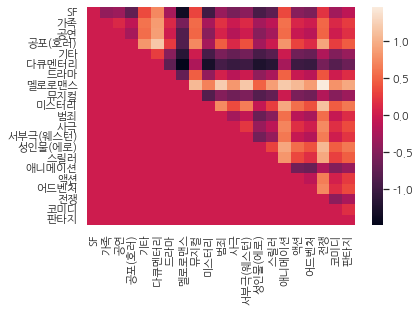

In [41]:
import numpy as np; 
import seaborn as sns; 
import matplotlib as plt
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name)
ax

시각화하여 보았을 때는 다큐멘터리가 전체적으로 반대되는 편향을 보여줌을 확인할 수 있었다.

# 3. POTG
## 3-1. 소감

#### " 😡사람을 따라가는 AI, 너 좀 혼나야겠다! "

전체적인 구조나 공식이 어려운 부분은 다행히 없었습니다. 다만 우리가 만든 인공지능이  
좋지 못하게 쓰이거나 혹은 누군가에게 상처를 주기 이전  
이 과정을 꼭 거쳐야 한다는 생각이 들었습니다!


## 3-2. 어려웠던 점과 극복방안

1. TF-IDF 에 따른 단어 추출에서 문제  
추출된 단어가 다른 장르들과 유사하게 겹치면서  
WEAT score 계산에 차질이 생겼습니다. 

처음에는 유사하게 들어가는 단어들을 모두 지운 뒤 새로 TF-IDF 를 만들려 했으나,
크게 차이가 없었습니다.

2. gensim 이용 간 어려움  
gensim 의 이용방법이 버전 upgrade 가 되면서 크게 바뀌었습니다  
때문에 버전 차이에 따른 사용법을 찾기 위해 고군분투했습니다.  

결과적으로 같은 내용을 다룬 분의 글이 참고가 되었습니다.